In [12]:
import os
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import numpy as np

In [4]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0 1852k    0     0  2856k      0  0:04:41 --:--:--  0:04:41 2871k
  0  786M    0 6238k    0     0  3784k      0  0:03:32  0:00:01  0:03:31 3790k
  1  786M    1 11.0M    0     0  4261k      0  0:03:09  0:00:02  0:03:07 4266k
  2  786M    2 16.1M    0     0  4540k      0  0:02:57  0:00:03  0:02:54 4544k
  2  786M    2 20.5M    0     0  4530k      0  0:02:57  0:00:04  0:02:53 4533k
  3  786M    3 25.4M    0     0  4611k      0  0:02:54  0:00:05  0:02:49 4838k
  3  786M    3 30.1M    0     0  4650k      0  0:02:53  0:00:06  0:02:47 4935k
  4  786M    4 35.4M    0     0  4747k      0  0:02:49  0:00:07  0:02:42 5004k
  5  786M    5 39.9M    0     0  4732k      0  0:02:50  0:00:08  0:02:42 4872k
  5  786M    5 44.2M    0     0  4692k      0  0:02

In [8]:
!tar -xf kagglecatsanddogs_5340.zip
!dir

 Volume in drive C is OS
 Volume Serial Number is 5833-CB4D

 Directory of c:\Users\muham\vs_code

08/19/2024  04:10 PM    <DIR>          .
08/18/2024  06:40 PM    <DIR>          ..
06/02/2024  07:48 PM         1,387,688 Better_knowledge_distillation.ipynb
05/09/2022  12:58 PM            24,876 CDLA-Permissive-2.0.pdf
05/05/2024  11:27 AM    <DIR>          ETH-hackathon-2024
04/27/2024  06:32 PM           963,439 face_cv.xml
08/19/2024  04:05 PM       824,887,076 kagglecatsanddogs_5340.zip
06/05/2024  04:39 PM    <DIR>          Miscellanous lab projects
06/04/2024  11:00 AM         8,846,280 model.h5
08/18/2024  10:06 AM        15,960,900 model.tflite
06/04/2024  12:37 PM         8,846,280 model_alp0.7_temp10_acc0.87.h5
08/19/2024  04:10 PM    <DIR>          PetImages
02/10/2017  09:51 AM               104 readme[1].txt
06/05/2024  10:37 PM    <DIR>          TAMUQ
08/17/2024  09:52 AM           226,142 tutorial_1.ipynb
08/18/2024  10:09 AM         3,266,644 tutorial_2_flowers_classific

In [9]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1578 images.


In [10]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Using 4684 files for validation.


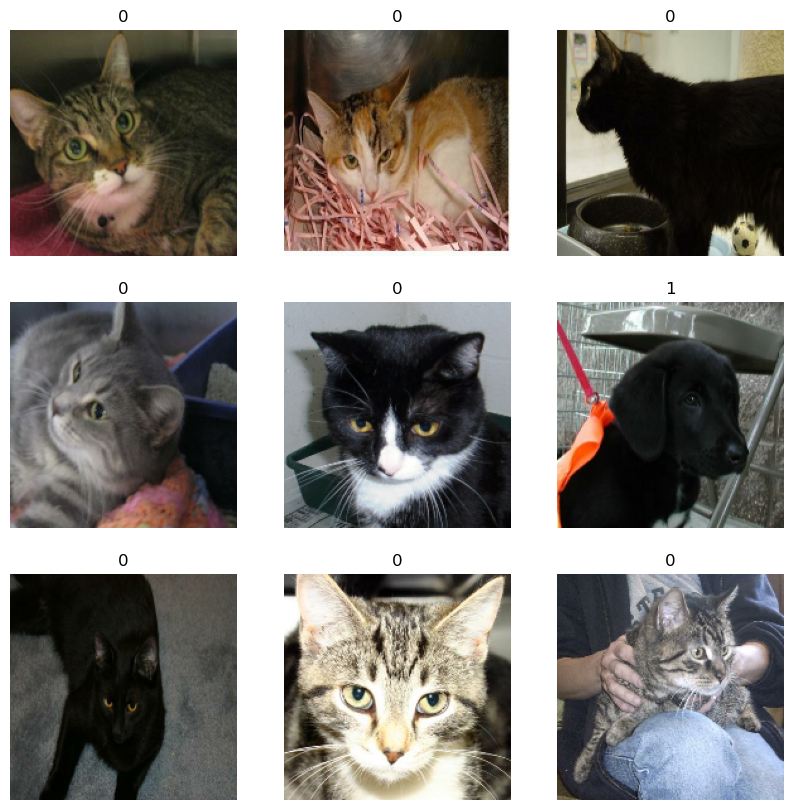

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [14]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

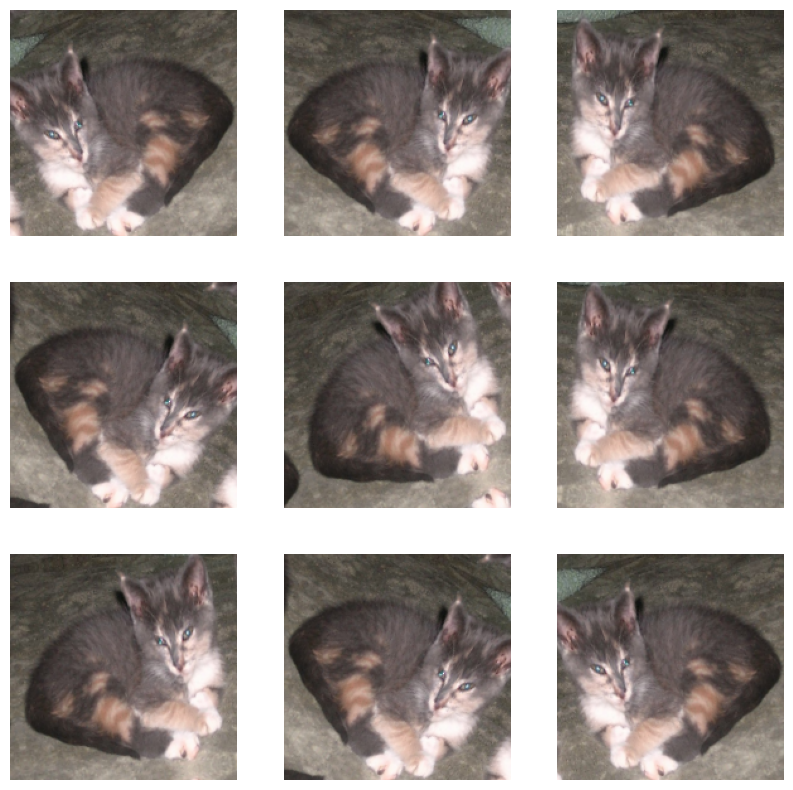

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [18]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [17]:
!pip install pydot

  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)


In [19]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/25


KeyboardInterrupt: 